# Variant Effect Prediction with OmniGenBench

This notebook demonstrates how to use various genomic foundation models for variant effect prediction. It processes genomic variants from a BED file, uses a reference genome, and predicts the functional effects of variants using deep learning models.

**Dataset Description:**
The dataset for this task consists of a BED file (`variant_effects_expression.bed`) containing human genetic variants associated with diseases, and the human reference genome (hg38). The BED file specifies the chromosome, start/end positions, reference allele, and alternative allele for each variant. The goal is to predict the functional impact of these variants by comparing the model's embeddings of the reference sequence versus the altered sequence. The data is sourced from the [`variant_effect_prediction`](https://huggingface.co/datasets/yangheng/variant_effect_prediction) dataset on Hugging Face.

**Estimated Runtime:**
This notebook performs inference only (no training). The runtime depends on the model size and the number of variants processed. On a single NVIDIA RTX 4090 GPU, running the analysis on the full dataset takes about **15-25 minutes**. If you uncomment the line to run on a small sample (10 examples), the process should complete in under **<1 minutes**.


## Notebook Structure

This notebook is organized into concise sections. Most core logic is moved to [`examples/variant_effect_prediction/utils.py`](https://github.com/COLA-Laboratory/OmniGenBench/blob/master/examples/variant_effect_prediction/utils.py) and imported here:

1. **Setup & Installation**: Install dependencies if needed.
2. **Import Libraries**: Load Python libraries.
3. **Configuration & Data Download**: Set paths/params and call `utils.download_vep_dataset` and `utils.download_ncbi_reference_genome`.
4. **Model Selection**: Pick a model to evaluate.
5. **Main Analysis Pipeline**: Use `utils.run_vep_analysis` to run the VEP pipeline.
6. **Results Overview**: Quick stats and preview.
7. **Visualization**: Plot score distributions.

This keeps the notebook minimal while utilities handle the heavy lifting.


## 1. Setup & Installation

This cell contains the necessary packages for running the notebook. If you have already installed them, you can skip this step. Otherwise, uncomment and run the cell.

In [ ]:
!pip install torch transformers pandas autocuda omnigenbench -U


## 2. Import Libraries

Import all the necessary libraries for genomic data processing, model inference, and analysis.

In [5]:
import warnings
import findfile, autocuda
import importlib, requests

# # download utils.py, see GitHub for detailed codes at: https://github.com/COLA-Laboratory/OmniGenBench/tree/master/examples/variant_effect_prediction
# url = "https://huggingface.co/datasets/yangheng/variant_effect_prediction/resolve/main/utils.py"
# response = requests.get(url)
# with open("utils.py", "wb") as f:
#     f.write(response.content)

utils_spec = importlib.util.spec_from_file_location("utils", "utils.py")
utils = importlib.util.module_from_spec(utils_spec)
utils_spec.loader.exec_module(utils)

warnings.filterwarnings('ignore')
print("Libraries imported successfully!")


Libraries imported successfully!


## 3. Configuration & Data Download

Set up the analysis parameters, file paths, and model selection here. You can easily change the `model_name` to test different genomic foundation models.

In [6]:
# Using utils for reusable logic
from utils import download_ncbi_reference_genome, download_vep_dataset
print("Core classes and functions imported from utils.")

local_dir = "vep_prediction_dataset"
download_vep_dataset(local_dir) # Uncomment to download the full dataset
download_ncbi_reference_genome()

# --- Main Configuration ---
BED_FILE = findfile.find_cwd_file("variant_effects_expression.bed")
FASTA_FILE = findfile.find_cwd_file("hg38.fa")


Core classes and functions imported from utils.
Downloaded vep_prediction_dataset/vep_dataset.zip
Extracted vep_dataset.zip into vep_prediction_dataset


hg38.fa.gz:   0%|          | 0.00/984M [00:00<?, ?B/s]

Extracting hg38.fa.gz...
Reference genome ready at hg38.fa


## 4. Model Selection

Choose a model to evaluate. All core processing (data loading, embeddings, scoring) is handled in `utils.py`.

In [7]:
# --- Available Models for Testing ---
AVAILABLE_MODELS = [
    'yangheng/OmniGenome-52M',
    'yangheng/OmniGenome-186M',
    'yangheng/OmniGenome-v1.5',
]
MODEL_NAME = AVAILABLE_MODELS[0]  # Model to use for predictions
print(f"Selected model: {MODEL_NAME}")


Selected model: yangheng/OmniGenome-52M


## 5. Main Analysis Pipeline

Run the VEP pipeline using `utils.run_vep_analysis` for a concise workflow.

In [11]:
# Import main pipeline from utils for a concise demo
from utils import run_vep_analysis

print("Main analysis pipeline imported from utils.")

# Setup device
compute_device = autocuda.auto_cuda()

print(f"Starting analysis on device: {compute_device}")
print("=" * 50)

# Run the analysis
results_df = run_vep_analysis(
    model_name=MODEL_NAME,
    bed_file=BED_FILE,
    fasta_file=FASTA_FILE,
    context_size=200,  # Context size (in base pairs) to include on each side of the variant
    batch_size=16,  # Batch size for model inference
    max_examples=10000,  # Set to None to run on the full dataset,
    device=compute_device
)

print("=" * 50)
print("Analysis completed!")

# Save results to CSV
output_filename = f"{MODEL_NAME.split('/')[-1]}_vep_predictions.csv"
results_df.to_csv(output_filename, index=False)
print(f"Results saved to: {output_filename}")


Main analysis pipeline imported from utils.
Starting analysis on device: cuda:0
--- Step 1: Initializing ---
--- Step 2: Loading Annotations ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Loading reference genome from hg38.fa...


/content/utils.py:115: ResourceWarning: unclosed file <_io.TextIOWrapper name='hg38.fa' mode='rt' encoding='utf-8'>
  self.genome_dict = SeqIO.to_dict(SeqIO.parse(reference_genome_path, "fasta"))


Loaded 455 chromosomes.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Processing 105263 variants.
--- Step 3: Loading Model: yangheng/OmniGenome-52M ---


Some weights of OmniGenomeModel were not initialized from the model checkpoint at yangheng/OmniGenome-52M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on cuda:0 with 52453345 parameters.
--- Step 4: Generating Sequences ---


Generating Sequences:   0%|          | 0/105263 [00:00<?, ?it/s]

--- Step 5: Computing Embeddings ---


OmniGenome:   0%|          | 0/626 [00:00<?, ?it/s]

OmniGenome:   0%|          | 0/626 [00:00<?, ?it/s]

--- Step 6: Calculating Scores ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Overall AUC based on 'mut_dist': 0.4934


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Analysis completed!
Results saved to: OmniGenome-52M_vep_predictions.csv


## 6. Results Overview

Preview the results and display basic statistics for the computed distances. This provides insights into the model's sensitivity to the variants.

In [9]:
print("Results Summary:")
print(results_df[['chromosome', 'start', 'end', 'ref', 'alt', 'cls_dist', 'mut_dist']].describe())

print("\nFirst 5 results:")
display(results_df[['chromosome', 'start', 'end', 'ref', 'alt', 'cls_dist', 'mut_dist']].head())


Results Summary:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


              start           end    cls_dist    mut_dist
count  1.010000e+02  1.010000e+02  101.000000  101.000000
mean   2.978280e+06  2.978680e+06    0.001803    0.350830
std    1.281962e+06  1.281962e+06    0.003294    0.208740
min    1.054836e+06  1.055236e+06    0.000000    0.099121
25%    2.143920e+06  2.144320e+06    0.000000    0.200195
50%    2.632543e+06  2.632943e+06    0.000977    0.271973
75%    3.826554e+06  3.826954e+06    0.001953    0.425781
max    5.982673e+06  5.983073e+06    0.018555    1.042969

First 5 results:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,chromosome,start,end,ref,alt,cls_dist,mut_dist
0,chr1,1054836,1055236,T,C,0.000977,0.537598
1,chr1,1070225,1070625,C,T,0.000977,0.135742
2,chr1,1094984,1095384,C,T,0.000000,0.397461
3,chr1,1189082,1189482,G,A,0.015137,0.244629
4,chr1,1189972,1190372,A,T,0.001953,0.533203


## 7. Visualization

Visualize the distributions of `cls_dist` and `mut_dist` to understand the model's behavior and sensitivity to genomic variants. These plots help identify patterns in the embeddings generated by the model.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


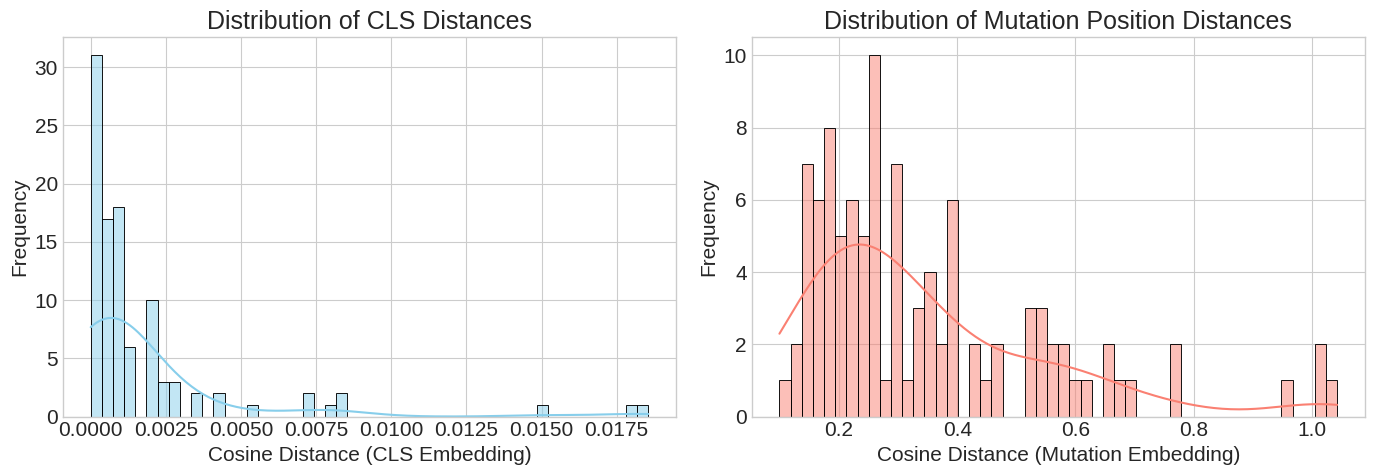

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(results_df['cls_dist'].dropna(), bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of CLS Distances')
axes[0].set_xlabel('Cosine Distance (CLS Embedding)')
axes[0].set_ylabel('Frequency')

sns.histplot(results_df['mut_dist'].dropna(), bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Mutation Position Distances')
axes[1].set_xlabel('Cosine Distance (Mutation Embedding)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## References
[BEND: Benchmarking DNA Language Models on biologically meaningful tasks](https://arxiv.org/abs/2311.12570)
